# Analisis en una tienda en línea internacional (Test A/B)

Lanzaron una prueba A/B y luego abandonaron, solo dejaron las especificaciones técnicas y los resultados de las pruebas.

### Descripción técnica
- Nombre de la prueba: `recommender_system_test`
- Grupos: А (control), B (nuevo embudo de pago)
- Launch date: 2020-12-07
- Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
- Fecha de finalización: 2021-01-01
- Audiencia: 15% de los nuevos usuarios de la región de la UE
- Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
- Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento `product_page`), instancias de agregar artículos al carrito de compras (`product_card`) y compras (`purchase`). En cada etapa del embudo `product_page → product_card → purchase`, habrá al menos un 10% de aumento.
- Número previsto de participantes de la prueba: 6 000

Descarga los datos de la prueba, comprueba si se ha realizado correctamente y analiza los resultados.

### Data
`ab_project_marketing_events_us.csv` (el calendario de eventos de marketing para 2020):
- `name`: el nombre del evento de marketing
- `regions`: regiones donde se llevará a cabo la campaña publicitaria
- `start_dt`: fecha de inicio de la campaña
- `finish_dt`: fecha de finalización de la campaña

`final_ab_new_users_upd_us.csv`(todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020):
- `user_id`
- `first_date`: fecha de inscripción
- `region`
- `device`: dispositivo utilizado para la inscripción

`final_ab_events_upd_us.csv` (todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021):
- `user_id`
- `event_dt`: fecha y hora del evento
- `event_name`: nombre del tipo de evento
- `details`: datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos `purchase`)

`final_ab_participants_upd_us.csv` (tabla con los datos de los participantes de la prueba):
- `user_id`
- `ab_test`: nombre de la prueba
- `group`: el grupo de prueba al que pertenecía el usuario

## Describe los objetivos del estudio.
Probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado para el 15% de los nuevos usuarios de la región de la UE, los cias se veran reflejados en la conversión de los usuarios, en las etapas de vistas de la página, agregar productos y compra.

**Hiportesis**: 
Dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento `product_page`), instancias de agregar artículos al carrito de compras (`product_card`) y compras (`purchase`). En cada etapa del embudo `product_page → product_card → purchase`, habrá al menos un 10% de aumento.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go

from scipy import stats as st
import statsmodels.stats.weightstats as sm

## Explora los datos (EDA):

In [2]:
df_marketing_events = pd.read_csv('ab_project_marketing_events_us.csv',
                                  dtype={'regions':'category'}, 
                                  parse_dates=['start_dt','finish_dt'])
print(df_marketing_events.info())
display(df_marketing_events.describe(include='all'))
display(df_marketing_events.head())
print('El dataSet tiene {} duplicados'.format(df_marketing_events.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     category      
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: category(1), datetime64[ns](2), object(1)
memory usage: 702.0+ bytes
None


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,NaN,NaN
top,Christmas&New Year Promo,APAC,NaN,NaN
freq,1,4,NaN,NaN
mean,NaN,NaN,2020-07-02 06:51:25.714285824,2020-07-07 10:17:08.571428608
min,NaN,NaN,2020-01-25 00:00:00,2020-02-07 00:00:00
25%,NaN,NaN,2020-03-23 12:00:00,2020-03-26 18:00:00
50%,NaN,NaN,2020-06-01 12:00:00,2020-06-05 12:00:00
75%,NaN,NaN,2020-10-31 18:00:00,2020-11-03 00:00:00
max,NaN,NaN,2020-12-30 00:00:00,2021-01-07 00:00:00


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


El dataSet tiene 0 duplicados


In [3]:
df_final_new_users = pd.read_csv('final_ab_new_users_upd_us.csv', 
                                 dtype={'region':'category',
                                         'device':'category'},
                                 parse_dates=['first_date'])
print(df_final_new_users.info())
display(df_final_new_users.describe(include='all'))
display(df_final_new_users.head())
print('El dataSet tiene {} duplicados'.format(df_final_new_users.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  category      
 3   device      58703 non-null  category      
dtypes: category(2), datetime64[ns](1), object(1)
memory usage: 1.0+ MB
None


,user_id,first_date,region,device
count,58703,58703,58703,58703
unique,58703,NaN,4,4
top,D72A72121175D8BE,NaN,EU,Android
freq,1,NaN,43396,26159
mean,NaN,2020-12-15 01:59:36.573599488,NaN,NaN
min,NaN,2020-12-07 00:00:00,NaN,NaN
25%,NaN,2020-12-11 00:00:00,NaN,NaN
50%,NaN,2020-12-15 00:00:00,NaN,NaN
75%,NaN,2020-12-20 00:00:00,NaN,NaN
max,NaN,2020-12-23 00:00:00,NaN,NaN


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


El dataSet tiene 0 duplicados


In [4]:
df_final_events = pd.read_csv('final_ab_events_upd_us.csv',
                              dtype={'event_name':'category'},
                              parse_dates=['event_dt'])
print(df_final_events.info())
display(df_final_events.describe(include='all'))
display(df_final_events.head())
print('El dataSet tiene {} duplicados'.format(df_final_events.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  category      
 3   details     60314 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(1), object(1)
memory usage: 10.1+ MB
None


,user_id,event_dt,event_name,details
count,423761,423761,423761,60314.000000
unique,58703,NaN,4,NaN
top,A3917F81482141F2,NaN,login,NaN
freq,36,NaN,182465,NaN
mean,NaN,2020-12-18 10:10:17.282395648,NaN,23.881219
min,NaN,2020-12-07 00:00:33,NaN,4.990000
25%,NaN,2020-12-14 03:05:18,NaN,4.990000
50%,NaN,2020-12-18 17:40:52,NaN,4.990000
75%,NaN,2020-12-22 13:51:17,NaN,9.990000
max,NaN,2020-12-30 23:36:33,NaN,499.990000


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


El dataSet tiene 0 duplicados


In [5]:
df_final_participants = pd.read_csv('final_ab_participants_upd_us.csv',
                                    dtype={'group':'category',
                                           'ab_test': 'category'})
print(df_final_participants.info())
display(df_final_participants.describe(include='all'))
display(df_final_participants.head())
print('El dataSet tiene {} duplicados'.format(df_final_participants.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   user_id  14525 non-null  object  
 1   group    14525 non-null  category
 2   ab_test  14525 non-null  category
dtypes: category(2), object(1)
memory usage: 142.1+ KB
None


,user_id,group,ab_test
count,14525,14525,14525
unique,13638,2,2
top,307C06C0E6F09B93,A,interface_eu_test
freq,2,8214,10850


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


El dataSet tiene 0 duplicados


**Formarteo de valores**
Se formatearon todas las columnas que contienes valores con fechas, estilo dateTime. Además se formatear ciertas columnas con valores especificos como categoricos, estas fueron:
- df_final_participants: group (2 categorias), ab_test (2 categorias)
- df_final_events: event_name (4 categorias)
- df_final_new_users: region (4 categorias), device (4 categorias)
- df_marketing_events: regions (6 categorias)

**Valores  ausentes**
Ninguno de los dataSets contiene valores ausentes

**Valores duplicados**
No se evidendencian valores duplicados


## Análisis exploratorio de datos:


### Estudia la conversión en las diferentes etapas del embudo.

In [6]:
df_final_events.groupby('event_name')['user_id'].count().sort_values(ascending=False)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19584\2874655695.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final_events.groupby('event_name')['user_id'].count().sort_values(ascending=False)


event_name
login           182465
product_page    120862
purchase         60314
product_cart     60120
Name: user_id, dtype: int64

### ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?

In [7]:
df_merge_participants_events = df_final_participants.merge(df_final_events, how='inner', on='user_id')
df_merge_final_participants_events = df_merge_participants_events.pivot_table(columns='group',
                                                                                    index='event_name',
                                                                                    values='user_id',
                                                                                    aggfunc='count').sort_values(by='B', 
                                                                                                                 ascending=False).reset_index()

df_merge_final_participants_events['ratio A(%)']= ((df_merge_final_participants_events['A']/df_merge_final_participants_events['A'].shift(2))*100).round(2)
df_merge_final_participants_events['ratio B(%)']= ((df_merge_final_participants_events['B']/df_merge_final_participants_events['B'].shift(2))*100).round(2)

df_merge_final_participants_events_a = df_merge_final_participants_events[['event_name', 'A', 'ratio A(%)']]
df_merge_final_participants_events_b = df_merge_final_participants_events[['event_name', 'B', 'ratio B(%)']]
display(df_merge_final_participants_events)

fig_a = go.Figure(go.Funnel(
    x=df_merge_final_participants_events_a['A'],
    y=df_merge_final_participants_events_a['event_name'],
    text=df_merge_final_participants_events_a['ratio A(%)'],
    textinfo="value+text"
))

fig_b =go.Figure(go.Funnel(
    x=df_merge_final_participants_events_b['B'],
    y=df_merge_final_participants_events_b['event_name'],
    text=df_merge_final_participants_events_b['ratio B(%)'],
    textinfo="value+text"
))
fig_a.show()
fig_b.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19584\3772595355.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_merge_final_participants_events = df_merge_participants_events.pivot_table(columns='group',


group,event_name,A,B,ratio A(%),ratio B(%)
0,login,25394,19311,NaN,NaN
1,product_page,16669,12292,NaN,NaN
2,product_cart,8023,6295,31.59,32.60
3,purchase,8619,6235,51.71,50.72


### ¿Hay usuarios que están presentes en ambas muestras?

In [8]:
unique_user_ids = df_final_participants['user_id'].unique()
filtered_df = df_final_participants[~df_final_participants['user_id'].isin(unique_user_ids)]
filtered_df

,user_id,group,ab_test


No existen valores presentes en ambas muestras, sin embargo se existen valores duplicados en los grupos muestrales

### ¿Cómo se distribuye el número de eventos entre los días?

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19584\1606272066.py:3: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



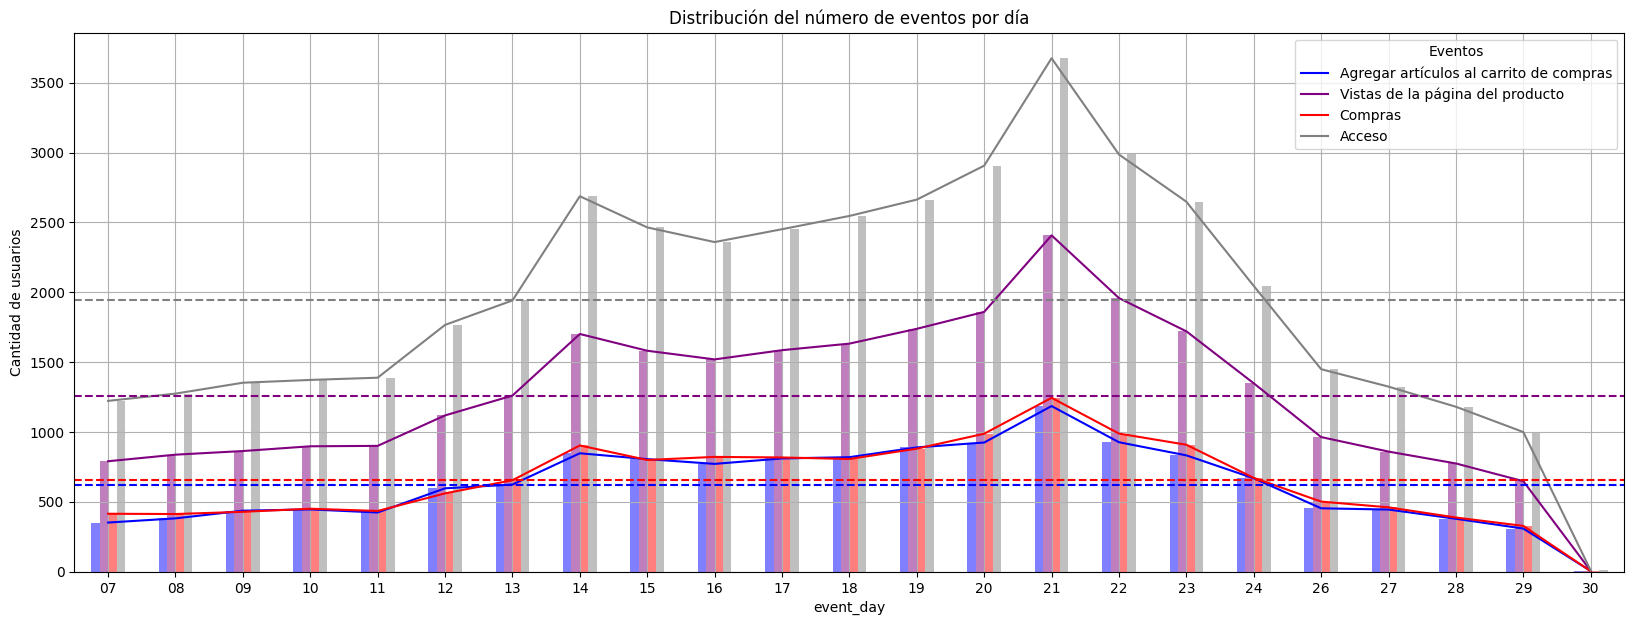

In [9]:
df_merge_participants_events['event_date']= df_merge_participants_events['event_dt'].dt.date
df_merge_participants_events['event_day']= df_merge_participants_events['event_dt'].dt.strftime('%d')
gpb_final_participants_events = df_merge_participants_events.pivot_table(index='event_day',
                                                                               columns='event_name',
                                                                               values='user_id',
                                                                               aggfunc='count')

ax = gpb_final_participants_events.plot(kind='bar',
                                        rot=0,
                                        xlabel='Fechas (Diciembre 2020)',
                                        ylabel='Cantidad de usuarios',
                                        figsize=[20,7],
                                        title='Distribución del número de eventos por día',
                                        alpha=0.5,
                                        color=['b','purple','r','gray'])

gpb_final_participants_events.plot(ax=ax, 
                                   grid=True,
                                   color=['b','purple','r','gray'])
ax.legend(['Agregar artículos al carrito de compras','Vistas de la página del producto','Compras','Acceso'], title='Eventos')
ax.axhline(y=(gpb_final_participants_events['login'].median()), color='gray', linestyle ='--')
ax.axhline(y=(gpb_final_participants_events['product_cart'].median()), color='b', linestyle ='--')
ax.axhline(y=(gpb_final_participants_events['product_page'].median()), color='purple', linestyle ='--')
ax.axhline(y=(gpb_final_participants_events['purchase'].median()), color='r', linestyle ='--')

plt.show()


## Peculiaridades en los datos que hay que tener en cuenta

Se muestra que el grupo A tiene mayor cantidad en los eventos de `'agregar artículos del carrito'` respecto a las `'compras'`, además que los valores del grupo A son de un 21.5% a un 27.6%.

La distribución de los usuarios evidencia una asimetria negativa, teniendo dos picos el día 14 y 21 de Diciembre, llegando a duplicar las cifras promedio, el último día mencionado.

## Evaluar los resultados de la prueba A|B:

### Valores netos de la prueba A|B

In [15]:
df_filter_ab_test=df_merge_participants_events.pivot_table(columns=['group','ab_test'],
                                                           index= 'event_name',
                                                           values='user_id',
                                                           aggfunc='count').reset_index()
df_filter_ab_test.columns=['event_name','a_interface_eu_test','a_recommender_system_test','b_interface_eu_test','b_recommender_system_test']
display(df_filter_ab_test.sort_values(by='a_interface_eu_test', ascending=False))
df_filter_ab_test_filter = df_filter_ab_test.iloc[:3]
df_filter_ab_test_filter = df_filter_ab_test_filter.sort_values(by='a_interface_eu_test', ascending=False)
display(df_filter_ab_test_filter)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19584\2498114193.py:1: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



,event_name,a_interface_eu_test,a_recommender_system_test,b_interface_eu_test,b_recommender_system_test
3,login,17122,8272,16746,2565
1,product_page,11341,5328,10918,1374
2,purchase,6074,2545,5570,665
0,product_cart,5541,2482,5617,678


,event_name,a_interface_eu_test,a_recommender_system_test,b_interface_eu_test,b_recommender_system_test
1,product_page,11341,5328,10918,1374
2,purchase,6074,2545,5570,665
0,product_cart,5541,2482,5617,678


werweetybujokperfgrh8emoikd

### Prueba Z: Comprobar la diferencia estadística entre las proporciones

**Hiportesis**
- H0:tvybumoikfmieyu7
- H1:hufenkmoiernfmk

In [11]:
a_interface_eu_test = df_filter_ab_test_filter['a_interface_eu_test']
mean_a_eu = np.mean(a_interface_eu_test)
std_dev_a_eu = np.std(a_interface_eu_test, ddof=1)
var_a_eu = a_interface_eu_test.var()
print('La media del grupo A del test eu es de {}, la varianza es {} y la desviación standas es de {}'.format(mean_a_eu.round(2),var_a_eu.round(2),std_dev_a_eu.round(2)))

b_interface_eu_test = df_filter_ab_test_filter['b_interface_eu_test']
mean_b_eu = np.mean(b_interface_eu_test)
std_dev_b_eu = np.std(b_interface_eu_test, ddof=1)
var_b_eu = b_interface_eu_test.var()
print('La media del grupo B del test eu es de {}, la varianza es {} y la desviación standas es de {}'.format(mean_b_eu.round(2),var_b_eu.round(2),std_dev_b_eu.round(2)))

alpha = 0.05
    
z_stat, p_value = st.ttest_ind(a_interface_eu_test, b_interface_eu_test)
print(f"\nValor de la estadística Z: {z_stat:.2f}")
print(f"Valor p: {p_value:.4f}")
if p_value < alpha:
    print("Se rechaza la hipótesis nula (H0): Hay una diferencia significativa entre las medias de los grupos según el valor Z stats de la prueba t-test individual.")
else:
    print("No se puede rechazar la hipótesis nula (H0): No hay evidencia suficiente para afirmar que hay una diferencia significativa entre las medias de los grupos según el valor Z stats de la prueba t-test individual.")

z_stat, p_value = sm.ztest(a_interface_eu_test, b_interface_eu_test, alternative='two-sided')
print("\nEstadístico Z:", z_stat)
print("Valor p:", p_value)
if p_value < alpha:
    print("Se rechaza la hipótesis nula: hay diferencias significativas entre las medias según la prueba Z test.")
else:
    print("No se puede rechazar la hipótesis nula: no hay suficiente evidencia para decir que hay diferencias significativas según la prueba Z test.")

La media del grupo A del test eu es de 7652.0, la varianza es 10277563.0 y la desviación standas es de 3205.86
La media del grupo B del test eu es de 7368.33, la varianza es 9450652.33 y la desviación standas es de 3074.19

Valor de la estadística Z: 0.11
Valor p: 0.9172
No se puede rechazar la hipótesis nula (H0): No hay evidencia suficiente para afirmar que hay una diferencia significativa entre las medias de los grupos según el valor Z stats de la prueba t-test individual.

Estadístico Z: 0.11061780409703868
Valor p: 0.9119194285058299
No se puede rechazar la hipótesis nula: no hay suficiente evidencia para decir que hay diferencias significativas según la prueba Z test.


In [12]:
a_interface_system_test = df_filter_ab_test_filter['a_recommender_system_test']
mean_a_sys = np.mean(a_interface_system_test)
std_dev_a_sys = np.std(a_interface_system_test, ddof=1)
var_a_sys = a_interface_system_test.var()
print('La media del grupo A del test es de {}, la varianza es {} y la desviación estándar es de {}'.format(mean_a_sys.round(2), var_a_sys.round(2), std_dev_a_sys.round(2)))

b_interface_system_test = df_filter_ab_test_filter['b_recommender_system_test']
mean_b_sys = np.mean(b_interface_system_test)
std_dev_b_sys = np.std(b_interface_system_test, ddof=1)
var_b_sys = b_interface_system_test.var()
print('La media del grupo B del test es de {}, la varianza es {} y la desviación estándar es de {}'.format(mean_b_sys.round(2), var_b_sys.round(2), std_dev_b_sys.round(2)))

alpha = 0.05

z_stat, p_value = st.ttest_ind(a_interface_eu_test, b_interface_eu_test)
print(f"\nValor de la estadística Z: {z_stat:.2f}")
print(f"Valor p: {p_value:.4f}")
if p_value < alpha:
    print("Se rechaza la hipótesis nula (H0): Hay una diferencia significativa entre las medias de los grupos según el valor Z stats de la prueba t-test individual.")
else:
    print("No se puede rechazar la hipótesis nula (H0): No hay evidencia suficiente para afirmar que hay una diferencia significativa entre las medias de los grupos según el valor Z stats de la prueba t-test individual.")

z_stat, p_value = sm.ztest(a_interface_system_test, b_interface_system_test, alternative='two-sided')
print("\nEstadístico Z:", z_stat)
print("Valor p:", p_value)
if p_value < alpha:
    print("Se rechaza la hipótesis nula: hay diferencias significativas entre las medias según la prueba Z test.")
else:
    print("No se puede rechazar la hipótesis nula: no hay suficiente evidencia para decir que hay diferencias significativas según la prueba Z test.")


La media del grupo A del test es de 3451.67, la varianza es 2641462.33 y la desviación estándar es de 1625.26
La media del grupo B del test es de 905.67, la varianza es 164544.33 y la desviación estándar es de 405.64

Valor de la estadística Z: 0.11
Valor p: 0.9172
No se puede rechazar la hipótesis nula (H0): No hay evidencia suficiente para afirmar que hay una diferencia significativa entre las medias de los grupos según el valor Z stats de la prueba t-test individual.

Estadístico Z: 2.6325381733008837
Valor p: 0.008474949865877848
Se rechaza la hipótesis nula: hay diferencias significativas entre las medias según la prueba Z test.


## Conclusiones 
- **Etapa EDA**

- **Resultados de la prueba A|B**